In [2]:
using Pkg
Pkg.activate(".")

  Activating project at `~/Desktop/julia_codes/GaussianExpansionCavityMethod.jl/examples/linear_OrnteinUhlenbeck`


In [3]:
using Revise 
using Random, Graphs, GaussianExpansionCavityMethod, SparseArrays, LinearAlgebra, Statistics, ProgressMeter, QuadGK, JLD2, OffsetArrays
using PowerLawSamplers: doubling_up_sampler
ProgressMeter.ijulia_behavior(:append)
using PyCall, Conda
import PyPlot as plt
using LaTeXStrings

rcParams = PyDict(plt.matplotlib["rcParams"])
rcParams["font.size"] = 8

nx = pyimport("networkx")
function to_networkx(g::Graphs.AbstractGraph)
    g_nx = nx.Graph()
    for v in vertices(g)
        g_nx.add_node(Int(v))
    end
    for e in edges(g)
        g_nx.add_edge(Int(src(e)), Int(dst(e)))
    end
    return g_nx
end

to_networkx (generic function with 1 method)

# Markov Chain Monte Carlo (MCMC)

## Single realization of disorder, stochasticity and initial conditions

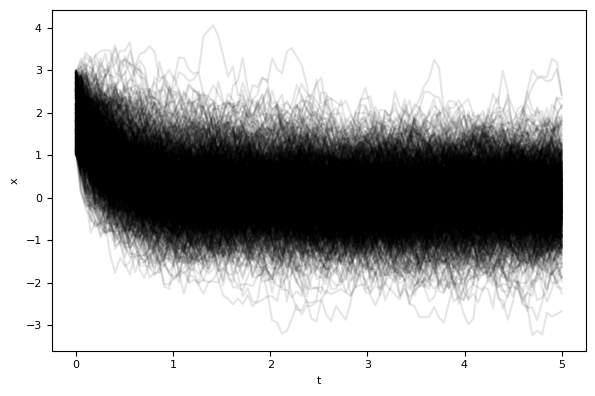

In [35]:
N, K = 1000, 4

rng = Xoshiro(1234)

lam, J, D = 2.5, 1.0/K, 1.0
Jmat = adjacency_matrix(random_regular_graph(N, K; rng=rng), Float64) 
@inbounds @fastmath for i in 1:N
    @inbounds @fastmath @simd for j in i+1:N
        if Jmat[i, j] != 0
            Jmat[i, j] = randn(rng) * sqrt(J)
            Jmat[j, i] = Jmat[i, j]
        end
    end
end
lambdas = fill(lam, N)

model = OUModel(K, Jmat, lambdas, D)

x0_min, x0_max = 1.0, 3.0
x0 = rand(rng, N) * (x0_max - x0_min) .+ x0_min
tmax = 5.0 
tsave=collect(range(0.0, tmax; length=100))

tvec, trajs = sample_OU(model, x0, tmax, tsave; rng=rng)

fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=true)
for i in 1:N
    ax.plot(tvec, view(trajs, i, :), color="k", alpha=0.1)
end
ax.set_xlabel("t")
ax.set_ylabel("x")

display(fig)

## Average over disorder, noise realizations and initial conditions

In [36]:
N, K = 500, 4

rng = Xoshiro(1234)

lam, J, D = 2.5, 1.0/K, 1.0

x0_min, x0_max = 0.0, 1.0
dt_mc = 1e-3
tmax = 5.0
tsave = collect(range(0.0, tmax; step=dt_mc*100))

nsim = 100

# Define ensemble model
model_ensemble = OUModelRRG(N, K, J, lam, D, x0_min, x0_max)

# Sample ensemble
tvals_alls, traj_alls = sample_ensemble_OU(model_ensemble, tmax, tsave, nsim; rng=rng, showprogress=true, dt=dt_mc);

CompositeException: TaskFailedException

    nested task error: InterruptException:
    Stacktrace:
     [1] Array
       @ ./boot.jl:477 [inlined]
     [2] getindex
       @ ./array.jl:400 [inlined]
     [3] make_seed(n::UInt32)
       @ Random ~/.julia/juliaup/julia-1.9.4+0.aarch64.apple.darwin14/share/julia/stdlib/v1.9/Random/src/RNGs.jl:295
     [4] seed!
       @ ~/.julia/juliaup/julia-1.9.4+0.aarch64.apple.darwin14/share/julia/stdlib/v1.9/Random/src/Xoshiro.jl:156 [inlined]
     [5] macro expansion
       @ ~/Desktop/julia_codes/GaussianExpansionCavityMethod.jl/src/linear_OrnteinUhlenbeck/sample.jl:141 [inlined]
     [6] (::GaussianExpansionCavityMethod.var"#17#threadsfor_fun#44"{GaussianExpansionCavityMethod.var"#17#threadsfor_fun#36#45"{Float64, Float64, Progress, ReentrantLock, Vector{UInt32}, Vector{Vector{Float64}}, Vector{Matrix{Float64}}, Vector{Xoshiro}, Vector{Float64}, Vector{Vector{Float64}}, Vector{OUModelEnsemble}, UnitRange{Int64}}})(tid::Int64; onethread::Bool)
       @ GaussianExpansionCavityMethod ./threadingconstructs.jl:206
     [7] #17#threadsfor_fun
       @ ./threadingconstructs.jl:173 [inlined]
     [8] (::Base.Threads.var"#1#2"{GaussianExpansionCavityMethod.var"#17#threadsfor_fun#44"{GaussianExpansionCavityMethod.var"#17#threadsfor_fun#36#45"{Float64, Float64, Progress, ReentrantLock, Vector{UInt32}, Vector{Vector{Float64}}, Vector{Matrix{Float64}}, Vector{Xoshiro}, Vector{Float64}, Vector{Vector{Float64}}, Vector{OUModelEnsemble}, UnitRange{Int64}}}, Int64})()
       @ Base.Threads ./threadingconstructs.jl:145

In [37]:
teq = 3.0
teq_idx = findfirst(tsave .> teq - dt_mc/2)
tvals_eq = tsave[teq_idx:end]

fig, axs = plt.subplots(2, 2, figsize=(6*2, 4*2), tight_layout=true)

mean_traj, std_traj, autocorr_traj = compute_stats_TTI(traj_alls, teq_idx)
# Only averages
for isim in 1:nsim
    mean, std, autocorr = compute_stats_TTI(traj_alls[isim], teq_idx)
    ax = axs[1,1]
    ax.plot(tvals_eq, mean, color="k", alpha=0.1)
    ax.fill_between(tvals_eq, mean .- std, mean .+ std, color="gray", alpha=0.05)
    ax = axs[2,1]
    ax.plot(tvals_eq, autocorr ./ autocorr[1], color="k", alpha=0.1)
end
ax = axs[1,1]
ax.set_ylabel("x")
ax.plot(tvals_eq, mean_traj, color="red")
ax.fill_between(tvals_eq, mean_traj .- std_traj, mean_traj .+ std_traj, color="red", alpha=0.1)
ax = axs[2,1]
ax.set_xlabel("t")
ax.set_ylabel("Ceq(t)")
ax.plot(tvals_eq, autocorr_traj ./ autocorr_traj[1], color="red")

# Plot all trajectories
ax = axs[1,2]
for isim in 1:nsim
    for i in 1:10
        ax.plot(tvals_alls[isim], view(traj_alls[isim],i,:), color="k", alpha=0.01)
    end
end

plt.display(fig)

InterruptException: InterruptException:

# GECaM approach

## Random Regular Graph with ferromagnetic interactions

In [99]:
N, K = 100, 4

rng = Xoshiro(1234)

lam, J, D = 1.1, 1.0/K, 1.0
Jmat = adjacency_matrix(random_regular_graph(N, K; rng=rng), Float64) .* J
lambdas = fill(lam, N)

x0_min, x0_max = 0.0, 2.0
gen_J(N, K, J_params; rng=Xoshiro(1234)) = deepcopy(Jmat)
gen_x0(N, x0_params; rng=Xoshiro(1234)) = rand(rng, N) .* (x0_params[2] - x0_params[1]) .+ x0_params[1]
J_params = [J]
x0_params = [x0_min, x0_max]

ensemble_model = OUModelEnsemble(N, K, gen_J, J_params, lambdas, D, gen_x0, x0_params)

dt_mc = 1e-2
tmax = 100.0
tsave_mc = collect(range(0.0, tmax; step=dt_mc))
T_mc = length(tsave_mc)

nsim = 100

# Sample ensemble
tvals_alls, traj_alls = sample_ensemble_OU(ensemble_model, tmax, tsave_mc, nsim; rng=rng, showprogress=true, dt=dt_mc);

Progress: 100%|███████████████████████████| Time: 0:00:01 (11.61 ms/it)


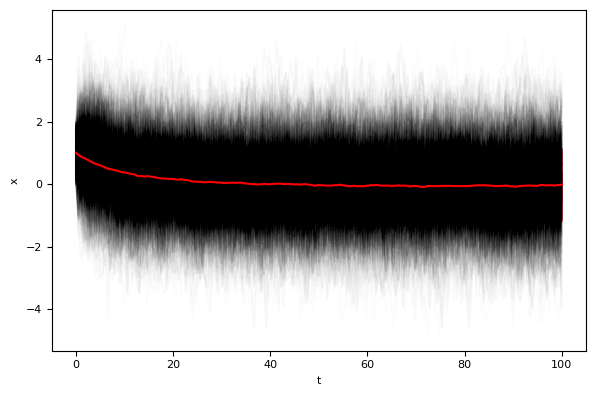

In [100]:
tvec_mc = collect(range(0.0, tmax; length=200))
tidxs_mc = [argmin(abs.(tsave_mc .- t)) for t in tvec_mc]

fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=true)

# Plot all trajectories
for isim in rand(rng, 1:nsim, 30)
    for i in rand(rng, 1:N, 50)
        ax.plot(tvec_mc, view(traj_alls[isim],i,tidxs_mc), color="k", alpha=0.01)
    end
end
# Plot mean and std
mean_traj, std_traj = compute_meanstd(traj_alls; time_indices=tidxs_mc)
ax.plot(tvec_mc, mean_traj, color="red")
ax.fill_between(tvec_mc, mean_traj .- std_traj, mean_traj .+ std_traj, color="red", alpha=0.5)
ax.set_ylabel("x")
ax.set_xlabel("t")

plt.display(fig)

In [101]:
model = OUModel(K, Jmat, lambdas, D)

dt_G = 1e-1

T_G = Int(20/dt_G)
nodes = run_cavity(model, dt_G, T_G; showprogress=true)

tvec_G = collect(range(0.0, dt_G*T_G; step = dt_G))

C, R = compute_averages(nodes, model, T_G)
mu = compute_mean(nodes, model, T_G);

Cavity update: 100%|██████████████████████| Time: 0:00:54 (50.36 ns/it)
Marginal update: 100%|████████████████████| Time: 0:00:04 (14.89 ns/it)


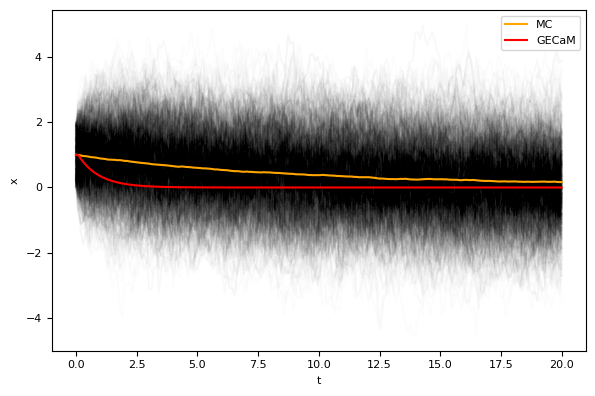

In [102]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=true)

tvec_mc = collect(range(0.0, dt_G*T_G; length=200))
tidxs_mc = [argmin(abs.(tsave_mc .- t)) for t in tvec_mc]

# Plot all trajectories
for isim in rand(rng, 1:nsim, 30)
    for i in rand(rng, 1:N, 50)
        ax.plot(tvec_mc, view(traj_alls[isim],i,tidxs_mc), color="k", alpha=0.01)
    end
end
# Plot mean and std
mean_traj, std_traj = compute_meanstd(traj_alls; time_indices=tidxs_mc)
ax.plot(tvec_mc, mean_traj, color="orange", label="MC")
ax.plot(tvec_G, mu, color="red", label="GECaM")
ax.set_ylabel("x")
ax.set_xlabel("t")
ax.legend(loc="upper right", fontsize=8)

plt.display(fig)

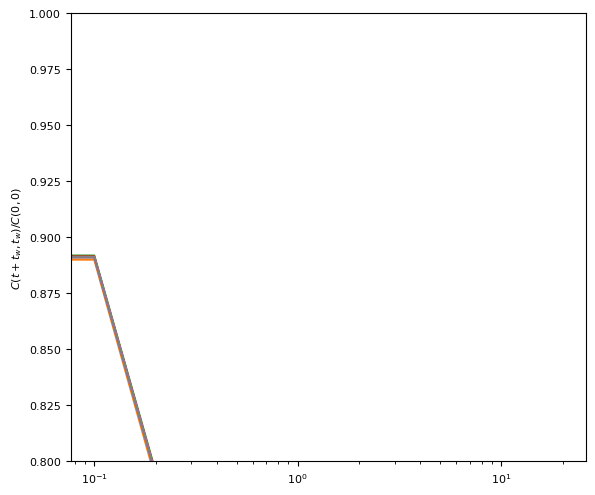

In [98]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5), tight_layout=true)

# correlations
tvec_mc = collect(range(0.0, dt_G*T_G; length=100))
tidxs_mc = [argmin(abs.(tsave_mc .- t)) for t in tvec_mc]
Cmc, _ = compute_autocorr(traj_alls; time_indices=tidxs_mc)
tws_idxs_G = collect(1:10:round(Int, length(tvec_G)/3))
tws = tvec_G[tws_idxs_G]

for i in 1:length(tws)
    tw = tws[i]
    tw_idx_G = tws_idxs_G[i]
    tw_idx_mc = argmin(tvec_mc .- tw)
    Cmc_tw = Cmc[tw_idx_mc:end, tw_idx_mc]
    C_tw = C.parent[tw_idx_G:end, tw_idx_G]
    #ax.scatter(tvec_mc[tw_idx_mc:end] .- tw, Cmc_tw, color="C$i", label="MC: tw = $tw")
    ax.plot(tvec_G[tw_idx_G:end] .- tw, C_tw ./ C_tw[1], color="C$i", label="GECaM: tw = $tw")
end
ax.set_ylabel(L"C(t+t_w, t_w)/C(0, 0)")
#ax.legend(loc="upper right", fontsize=8)
ax.set_xscale("log")
#ax.set_yscale("log")
ax.set_ylim(8e-1, 1.0)

plt.display(fig)

In [67]:
tws

7-element Vector{Float64}:
 0.0
 1.0
 2.0
 3.0
 4.0
 5.0
 6.0

In [91]:
for i in 1:size(C.parent, 1)
    C.parent[:, i] ./= C.parent[i, i]
end
C.parent

201×201 Matrix{Float64}:
 1.0          0.0          0.0          …  0.0       0.0       0.0       0.0
 0.89         1.0          0.0             0.0       0.0       0.0       0.0
 0.792225     0.890274     1.0             0.0       0.0       0.0       0.0
 0.705303     0.792713     0.890538        0.0       0.0       0.0       0.0
 0.628017     0.705954     0.793182        0.0       0.0       0.0       0.0
 0.559287     0.628789     0.706581     …  0.0       0.0       0.0       0.0
 0.498158     0.560147     0.629534        0.0       0.0       0.0       0.0
 0.44378      0.499076     0.560976        0.0       0.0       0.0       0.0
 0.395399     0.444734     0.499962        0.0       0.0       0.0       0.0
 0.352348     0.39637      0.445653        0.0       0.0       0.0       0.0
 ⋮                                      ⋱                                ⋮
 1.26618e-9   1.44195e-9   1.6396e-9       0.0       0.0       0.0       0.0
 1.14324e-9   1.30195e-9   1.48043e-9      0.0       

In [71]:
tws_idxs_G

7-element Vector{Int64}:
  1
 11
 21
 31
 41
 51
 61